# Portfolio Optimization



**May 17, 2023 <br/>**
**For SMU Quantum in Finace Course by Prof. Paul Griffin<br>**
This tutorial was adapted from notebooks by _Julien Gacon (jul@zurich.ibm.com) IBM Research - Zurich_ and _Abby Mitchell - Quantum Developer Advocate, IBM Quantum._

## How to Use this Notebook in your IBM Quantum Lab Account



1. Go to https://qisk.it/smuQfinance23 for the workshop resources

<img src="qrcode.png" width=300>

2. Click 'raw' button in GitHub, this will open the notebook file in a new tab

<img src="raw_button.png" width=600>

3. Right click on the raw file and save the file in jupyter notebook format (`.ipynb`)

<img src="save.png" width=600>

4. In IBM Quantum Lab, select upload button on in top left and upload the notebook file

<img src="upload_button.png" width=600>

5. If you didn't save it in `.ipynb` format you can rename the file in the jupyter lab

<img src="rename_button.png" width=600>

6. Now you can open the notebook in your IBM Quantum Lab environment! (note: if you want the images to display in your lab version you will need to download them from the github folder where the notebook is and upload it into your lab folder as well)

<img src="open_notebook.png" width=600>


## Finance  + Quantum Computing?

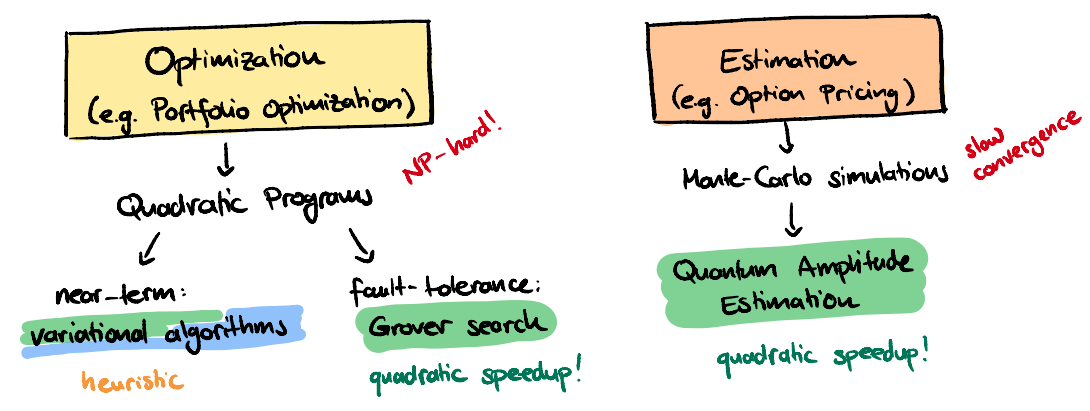

# Qiskit overview: Main Packages

![](qiskit_overview.png)





### Including the Ecosystem:
![](ecosystem.png)

## Qiskit Finance Module

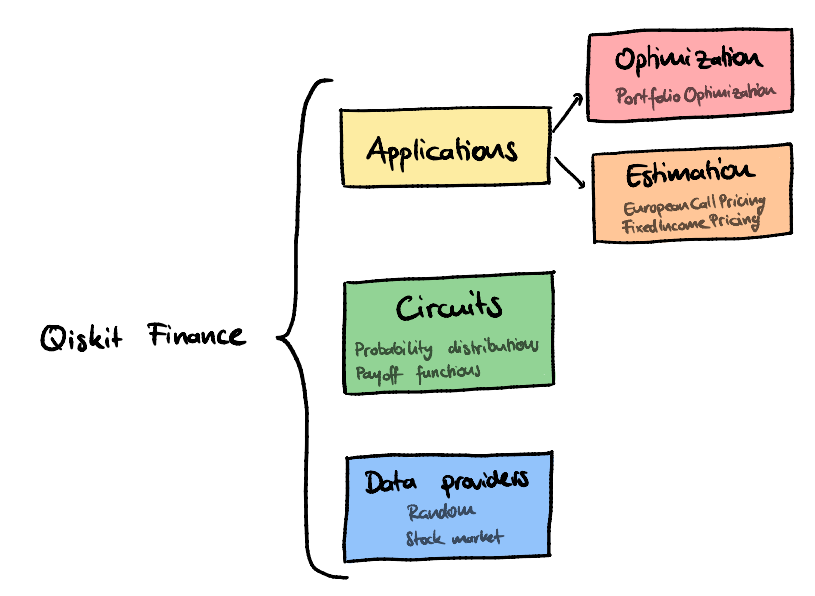

## Goal: Portfolio optimization (Prototyping breadth, not conceptual depth)

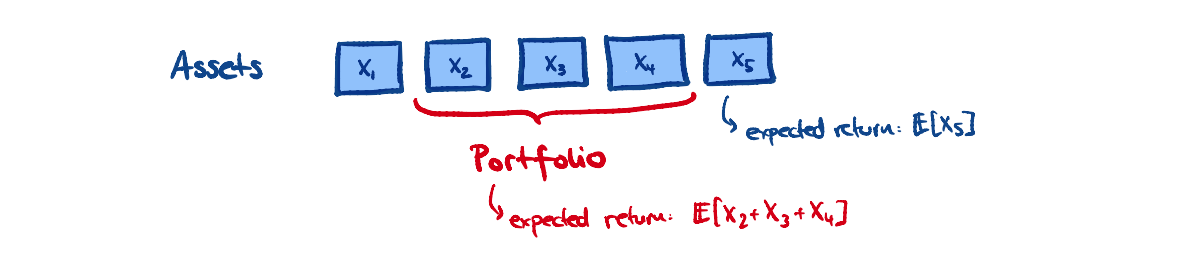

How can we optimize the portfolio to have the maximum return but at the same time has a small risk?

### Asset modelling

Collection of assets: Modelled with a multivariate probability distribution $\vec X = (X_1, ..., X_n)$.

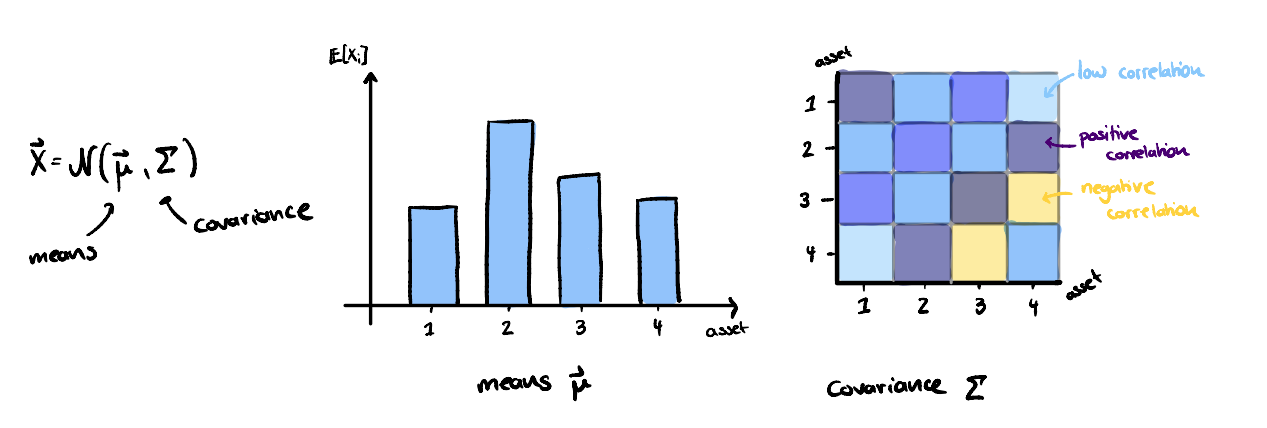

Optimal solution $\vec x^*$:

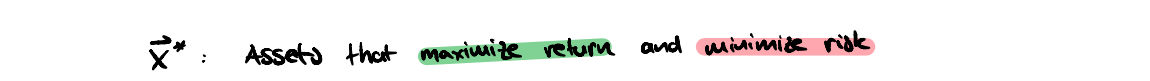

Or in a formula:

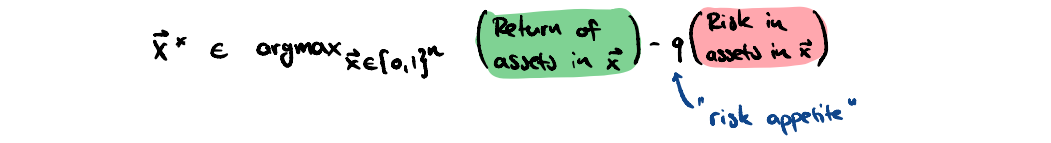

There are different ways to quantify risk -- first we'll define it as the _variance_ of the joint distribution:

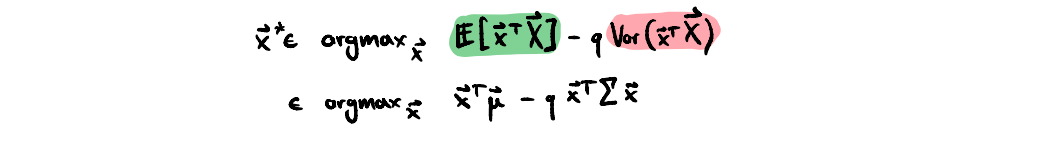

This is nothing but a quadratic program! These are well-studied and we can solve them with Qiskit.

## Introduction

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) or the Quantum Approximate Optimization Algorithm (`QAOA`) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

In [1]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](11_time_series.ipynb)

In [2]:
# set number of assets (= number of qubits)
num_assets = 7
seed = 200

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

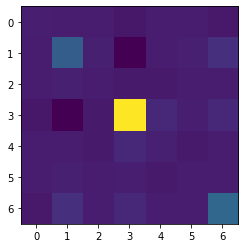

In [3]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

If you wish, you can look into the underlying pseudo-random time-series using. Please note that the private class members (starting with underscore) may change in future releases of Qiskit.

The underlying evolution of stock prices:


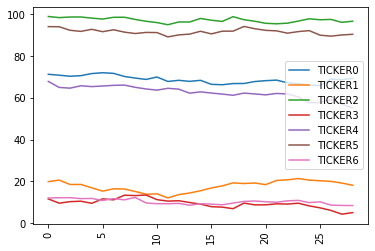

In [4]:
print("The underlying evolution of stock prices:")
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

### [Optional] Setup token to access recent, fine-grained time-series

If you would like to download professional data, you will have to set-up a token with one of the major providers. Let us now illustrate the data with NASDAQ Data on Demand, which can supply bid and ask prices in arbitrary resolution, as well as aggregates such as daily adjusted closing prices, for NASDAQ and NYSE issues.


If you don't have NASDAQ Data on Demand license, you can contact NASDAQ (cf. https://business.nasdaq.com/intel/GIS/Nasdaq-Data-on-Demand.html) to obtain a trial or paid license.

If and when you have access to NASDAQ Data on Demand using your own token, you should replace REPLACE-ME below with the token. 
To assure the security of the connection, you should also have your own means of validating NASDAQ's certificates. The DataOnDemandProvider constructor has an optional argument `verify`, which can be `None` or a string or a boolean. If it is `None`, certify certificates will be used (default). If verify is a string, it should be pointing to a certificate for the HTTPS connection to NASDAQ (dataondemand.nasdaq.com), either in the form of a CA_BUNDLE file or a directory wherein to look.


In [9]:
token = "REPLACE-ME"
if token != "REPLACE-ME":
    try:
        data = DataOnDemandProvider(
            token=token,
            tickers=["GOOG", "AAPL"],
            start=datetime.datetime(2016, 1, 1),
            end=datetime.datetime(2016, 1, 2),
        )
        data.run()
        for (cnt, s) in enumerate(data._tickers):
            plt.plot(data._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")

Another major vendor of stock market data is Exchange Data International (EDI), whose API can be used to query over 100 emerging and frontier markets that are Africa, Asia, Far East, Latin America and Middle East, as well as the more established ones. See:
https://www.exchange-data.com/
for an overview of the coverage.

The access again requires a valid access token to replace REPLACE-ME below. The token can be obtained on a trial or paid-for basis at:
https://data.nasdaq.com/sign-up

In [10]:
token = "REPLACE-ME"
if token != "REPLACE-ME":
    try:
        data = ExchangeDataProvider(
            token=token,
            tickers=["AEO", "ABBY", "ADIG", "ABF", "AEP", "AAL", "AGK", "AFN", "AAS", "AEFS"],
            stockmarket=StockMarket.LONDON,
            start=datetime.datetime(2018, 1, 1),
            end=datetime.datetime(2018, 12, 31),
        )
        data.run()
        for (cnt, s) in enumerate(data._tickers):
            plt.plot(data._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")

One can also access Yahoo Finance Data, no token needed, from Yahoo! Finance.

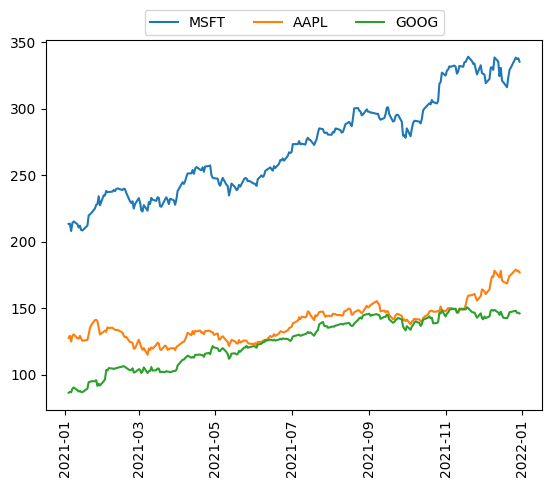

In [11]:
try:
    data = YahooDataProvider(
        tickers=["MSFT", "AAPL", "GOOG"],
        start=datetime.datetime(2021, 1, 1),
        end=datetime.datetime(2021, 12, 31),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

# Converting to quadratic program

In [5]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00011624822713042303*x_0^2 + 0.00011662270894401..., 7 variables, 1 constraints, 'Portfolio optimization'>

We define some utility methods to print and display the results in a nice format.

In [6]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [7]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(eval_count, weights, obj_func_eval, meta):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Recap on the Variational Quantum Eigensolver

Goal: Find ground state $|\Psi\rangle$ of the Hamiltonian $H$.

Idea: Choose model $|\phi(\theta)\rangle$ that can approximate $|\Psi\rangle$ well and minimize the energy

$$
    \theta^* = \text{argmin}_\theta E(\theta) = \text{argmin}_\theta \langle\phi(\theta)|H|\phi(\theta)\rangle 
$$

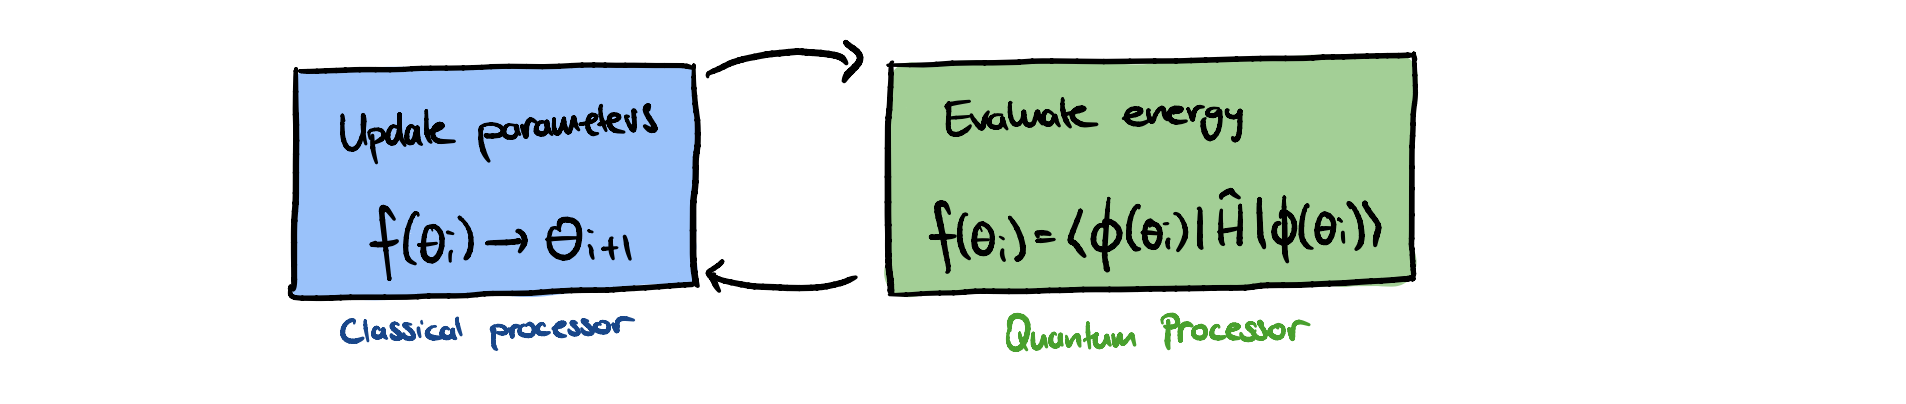

### Solving the program with the VQE

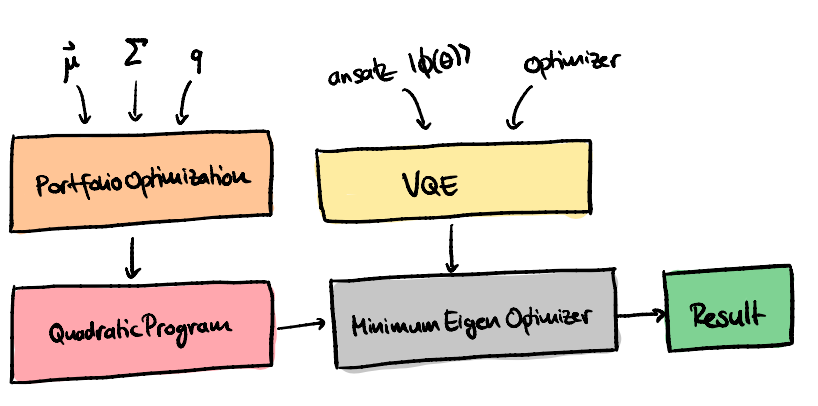

## Solution using `SamplingVQE`
We can now use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) to solve the problem. We will specify the optimizer and variational form to be used.

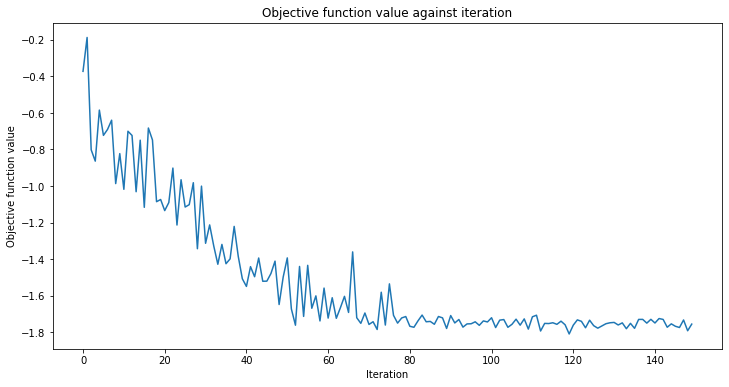

Optimal: selection [1. 0. 1. 0. 0. 1. 0.], value 0.0033

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 1 1 1]	0.0218		0.2812
[1 1 1 0 0 0 0]	0.0056		0.1729
[0 1 1 0 0 0 0]	0.0045		0.0996
[1 0 1 0 1 0 0]	0.0093		0.0654
[0 1 0 0 0 1 1]	0.0193		0.0430
[0 1 0 0 1 0 1]	0.0250		0.0420
[1 1 1 1 0 0 0]	0.0341		0.0391
[0 0 0 0 1 0 1]	0.0203		0.0244
[0 0 1 0 1 1 0]	0.0096		0.0215
[0 1 0 0 0 0 1]	0.0175		0.0205
[0 1 1 1 0 0 0]	0.0332		0.0166
[0 0 0 1 1 1 1]	0.0541		0.0156
[0 1 1 0 0 0 1]	0.0188		0.0137
[0 0 1 0 1 1 1]	0.0228		0.0127
[1 0 1 1 1 0 0]	0.0402		0.0098
[0 0 0 0 0 1 1]	0.0143		0.0098
[1 1 1 0 0 1 0]	0.0074		0.0098
[1 0 1 0 0 0 0]	0.0018		0.0078
[0 1 0 0 1 1 1]	0.0268		0.0078
[0 0 1 0 1 0 0]	0.0082		0.0078
[0 1 0 1 1 0 1]	0.0555		0.0068
[1 1 0 0 0 0 1]	0.0184		0.0059
[0 0 1 1 1 0 0]	0.0394		0.0059
[1 0 0 0 1 1 1]	0.0227		0.0049
[1 1 1 0 0 0 1]	0.0197		0.0039
[1 0 0 0 1 1 0]	0.0099		0.0029
[0 1

In [8]:
from qiskit.utils import algorithm_globals
objective_func_vals = []
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=150)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla, callback=callback_graph)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp) 

print_result(result)

### Solution using `QAOA`

We also show here a result using the Quantum Approximate Optimization Algorithm (`QAOA`). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

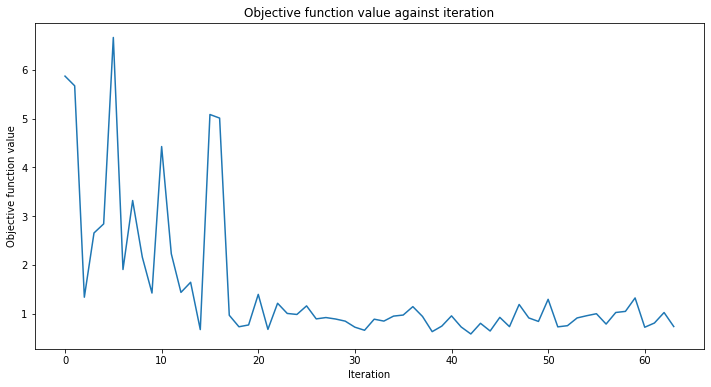

Optimal: selection [1. 0. 1. 0. 0. 1. 0.], value 0.0033

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 1 1 1]	0.0596		0.0811
[1 1 0 0 1 0 1]	0.0260		0.0332
[0 1 1 0 1 0 1]	0.0263		0.0332
[0 0 0 0 0 0 0]	0.0000		0.0322
[1 1 1 0 0 0 1]	0.0197		0.0293
[1 0 0 0 1 1 1]	0.0227		0.0293
[0 0 1 1 1 1 0]	0.0410		0.0283
[1 0 1 0 0 1 1]	0.0162		0.0273
[1 1 1 0 0 1 0]	0.0074		0.0254
[1 1 1 1 0 0 0]	0.0341		0.0234
[1 0 1 1 0 0 1]	0.0456		0.0225
[0 0 0 1 1 1 1]	0.0541		0.0215
[1 1 1 0 1 0 0]	0.0131		0.0215
[1 1 0 1 0 0 1]	0.0478		0.0215
[0 1 1 0 0 1 1]	0.0206		0.0215
[0 1 1 0 1 1 0]	0.0136		0.0215
[1 1 0 1 0 1 0]	0.0349		0.0205
[0 1 0 1 0 1 1]	0.0491		0.0205
[0 1 1 1 0 0 1]	0.0483		0.0205
[0 1 1 1 1 0 0]	0.0415		0.0195
[0 0 1 1 1 0 1]	0.0533		0.0195
[1 0 1 1 0 1 0]	0.0336		0.0195
[1 1 0 0 0 1 1]	0.0202		0.0195
[0 1 0 0 1 1 1]	0.0268		0.0195
[0 1 1 1 0 1 0]	0.0351		0.0186
[1 1 0 0 1 1 0]	0.0136		0.0186
[0 0

In [67]:
algorithm_globals.random_seed = 1234
objective_func_vals = []

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3, callback=callback_graph)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

## NumPyMinimumEigensolver (as a classical reference)

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [64]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 0. 1. 0.], value 0.0033

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0 1 0]	0.0033		1.0000


# Running on real hardware using Qiskit Runtime

## Primitives - New(ish) Feature 🎉

To understand Qiskit Runtime Primitives we need to take a trip down IBM Quantum memory lane...



![](circuit_flow.png)

![](primitives.png)

![](primitives_comparison.png)

![](sampler_estimator.png)


![](primitives_code.png)

### Why use runtime primitives?

TL;DR - it's a lot faster

### Run your routine using Qiskit runtime!



In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
from qiskit_ibm_provider import IBMProvider, least_busy

# QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
)

# Get the least-busy backend 
# provider = IBMProvider(instance='ibm-q/open/main')
# backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 1 and
#                                    not b.configuration().simulator and b.status().operational==True))

# print("The best backend is " + backend.name)
# backend = backend.name

In [10]:
# For simulator, comment this out for real backend
backend = "ibmq_qasm_simulator"

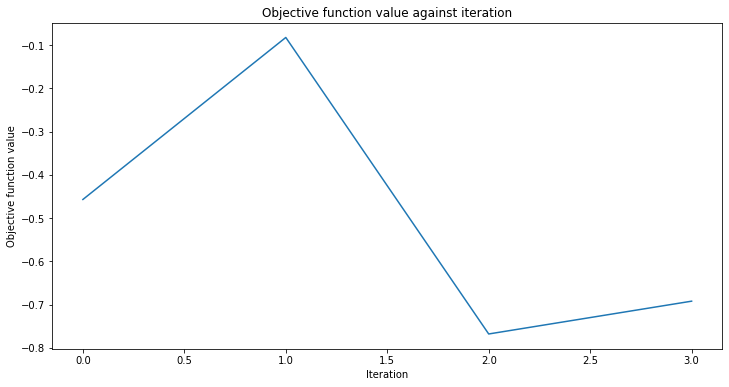

In [ ]:
from qiskit.utils import algorithm_globals
objective_func_vals = []
algorithm_globals.random_seed = 1234
options = Options()

with Session(service=service, backend=backend) as session:
    cobyla = COBYLA()
    cobyla.set_options(maxiter=150)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    vqe_mes = SamplingVQE(Sampler(), ansatz=ry, optimizer=cobyla, callback=callback_graph)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qp) 
    print_result(result)

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright